In [46]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
import os
os.listdir('/content/drive/My Drive/Temu Kembali Citra/Dataset')

['train', 'val', 'test']

In [48]:
%cd '/content/drive/My Drive/Temu Kembali Citra'

/content/drive/My Drive/Temu Kembali Citra


In [49]:
import numpy as np
import json
import os
import cv2
import copy
import sklearn.metrics as metric
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import matplotlib.pyplot as plt
import matplotlib

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *

In [50]:
!pip install split-folders
import splitfolders
input_folder = "eye disease"
output = "Dataset" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 4217 files [00:57, 73.72 files/s] 


In [51]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 16
IMAGE_SIZE = (128, 128)
checkpoint_path = "training_1_40_subclass_cp/cp.ckpt"
feature_path = "training_1_40_subclass_feature.json"
model_path = "training_1_40_subclass_model.h5"
history_path = "training_1_40_subclass_history.json"
base_dataset = "Dataset"
class_dir = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [52]:
print("[INFO] indexing file images Otomatch dataset...")
type_dataset = ['val', 'train']
dataset_train = []
dataset_val = []
for type_set in type_dataset:
    for class_item in class_dir:
        cur_dir = os.path.join(base_dataset, type_set, class_item)
        for file in os.listdir(cur_dir):
            if type_set == 'train':
                dataset_train.append(os.path.join(cur_dir, file))
            else:
                dataset_val.append(os.path.join(cur_dir, file))

print("[INFO] load images Otomatch dataset...")
#  load images
train_images = []
val_images = []
for type_set in type_dataset:
    cur_dataset = dataset_train if type_set == 'train' else dataset_val
    for image_path in cur_dataset:
        if ".jpg" in image_path:
            image = cv2.imread(image_path)
            image = cv2.resize(image, IMAGE_SIZE)
            if type_set == 'train':
                train_images.append(image)
            else:
                val_images.append(image)

[INFO] indexing file images Otomatch dataset...
[INFO] load images Otomatch dataset...


In [53]:
# normalization
print("[INFO] normalization...")
train_x = np.array(train_images).astype("float32") / 255.0
val_x = np.array(val_images).astype("float32") / 255.0

[INFO] normalization...


In [54]:
class ConvAutoEncoder:
    """
    Core Convolutional AutoEncoder
    This class included with build method you can adjust of width height and depth of image
    default filters 128, and latent dimension 48
    """
    @staticmethod
    def build(width, height, depth, filters=(128,), latent_dim=48):

        input_shape = (height, width, depth)
        channel_dim = -1

        base_model = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=input_shape)
        base_model.trainable = False
        inputs = base_model.input
        #x = base_model.output
        #base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
        #image_input = base_model.input
        #inputs = base_model.layers[-1].output
        #inputs = layers.Input(input_shape, name='anchor')

        #inputs = layers.Input(shape=input_shape)
        x = inputs
        # Encoder layer
        for f in filters:
            x = layers.Conv2D(f, (3, 3), strides=2, padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=channel_dim, name='enc_filter_' + str(f))(x)
        volume_size = K.int_shape(x)
        x = layers.Flatten()(x)
        # Latent layer
        latent = layers.Dense(latent_dim, name="encoded")(x)
        # Decoder layer
        x = layers.Dense(np.prod(volume_size[1:]))(latent)
        x = layers.Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
        # Reverse on decoder
        for f in filters[::-1]:
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=channel_dim, name='dec_filter_' + str(f))(x)
        x = layers.Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = layers.Activation("sigmoid", name="decoded")(x)
        #outputs = layers.Activation("softmax", name="decoded")(x)
        auto_encoder = Model(inputs, outputs, name="auto_encoder")
        return auto_encoder

In [55]:
print("[INFO] building auto encoder...")
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_loss",
    verbose = 1,
    mode='min',
    save_best_only=True)
auto_encoder.compile(loss="mse", optimizer=opt, metrics='accuracy')
auto_encoder.summary()

[INFO] building auto encoder...
Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_1019 (Conv2D)        (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 enc_filter_128 (BatchNormal  (None, 64, 64, 128)      512       
 ization)                                                        
                                                                 
 flatten_4 (Flatten)         (None, 524288)            0         
                                                                 
 encoded (Dense)             (None, 48)                25165872  
                      

In [56]:
# train the convolutional auto encoder
print("[INFO] training auto encoder...")
H = auto_encoder.fit(
    train_x, train_x,
    shuffle=True,
    validation_data=(val_x, val_x),
    epochs=EPOCHS,
    callbacks = [checkpoint_callback], batch_size=BS)

[INFO] training auto encoder...


Epoch 1/100
151/151 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.7241
Epoch 1: val_loss improved from inf to 0.03469, saving model to training_1_40_subclass_cp/cp.ckpt
151/151 [==============================] - 17s 104ms/step - loss: 0.0317 - accuracy: 0.7241 - val_loss: 0.0347 - val_accuracy: 0.7476
Epoch 2/100
150/151 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.7603
Epoch 2: val_loss improved from 0.03469 to 0.02527, saving model to training_1_40_subclass_cp/cp.ckpt
151/151 [==============================] - 13s 84ms/step - loss: 0.0070 - accuracy: 0.7601 - val_loss: 0.0253 - val_accuracy: 0.7469
Epoch 3/100
150/151 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.7599
Epoch 3: val_loss improved from 0.02527 to 0.01331, saving model to training_1_40_subclass_cp/cp.ckpt
151/151 [==============================] - 13s 88ms/step - loss: 0.0057 - accuracy: 0.7596 - val_loss: 0.0133 - val_accuracy: 0.7469
Epoch 4

In [57]:
with open(history_path, 'w') as f:
    json.dump(H.history, f)
auto_encoder.save(model_path)

In [58]:
reconstruction_mse = auto_encoder.evaluate(val_x, val_x, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
print("Test Loss:", reconstruction_mse[0])
print("Test Accuracy:", reconstruction_mse[1])

Convolutional autoencoder MSE: [0.0008313843281939626, 0.8235158920288086]
Test Loss: 0.0008313843281939626
Test Accuracy: 0.8235158920288086


In [59]:
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
# load our auto_encoder from disk
print("[INFO] loading auto encoder model...")
auto_encoder.load_weights(checkpoint_path)

# create the encoder model which consists of *just* the encoder
# portion of the auto encoder
encoder = Model(inputs=auto_encoder.input, outputs=auto_encoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(train_x)

[INFO] loading auto encoder model...
[INFO] encoding images...
76/76 [==============================] - 1s 7ms/step


In [60]:
indexes = list(range(0, train_x.shape[0]))
features_array = [[float(x) for x in y] for y in features]
labels = [path.split("/")[2] for path in dataset_train]
data = {"indexes": indexes, "features": features_array, "locations": dataset_train, "labels":labels}

In [61]:
with open(feature_path, 'w') as f:
    json.dump(data, f)

In [62]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

In [63]:
def perform_search(query_features, indexed_train, max_results=5):
	retrieved = []
	for idx in range(0, len(indexed_train["features"])):
		distance = euclidean(query_features, indexed_train["features"][idx])
		retrieved.append((distance, idx))
	retrieved = sorted(retrieved)[:max_results]
	return retrieved

In [64]:
print("[INFO] indexing file images Otomatch dataset...")
# indexing file images
dataset = []
for class_item in class_dir:
    cur_dir = os.path.join(base_dataset, 'test', class_item)
    for file in os.listdir(cur_dir):
        dataset.append(os.path.join(cur_dir, file))
print("test len to retrieving:", len(dataset))
print("[INFO] load test images Otomatch dataset...")
#  load images
images = []
for image_path in dataset:
    if ".jpg" in image_path:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        images.append(image)

[INFO] indexing file images Otomatch dataset...
test len to retrieving: 531
[INFO] load test images Otomatch dataset...


In [65]:
# normalization
print("[INFO] normalization...")
test_x = np.array(images).astype("float32") / 255.0

[INFO] normalization...


In [66]:
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
# load our auto_encoder from disk
print("[INFO] loading auto encoder model...")
auto_encoder.load_weights(checkpoint_path)
with open(feature_path) as f:
  training_indexed = json.load(f)

# create the encoder model which consists of *just* the encoder
# portion of the auto encoder
encoder = Model(inputs=auto_encoder.input,
	outputs=auto_encoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features_retrieved = encoder.predict(test_x)

[INFO] loading auto encoder model...


[INFO] encoding images...
11/11 [==============================] - 0s 6ms/step


In [67]:
query_indexes = list(range(0, test_x.shape[0]))
label_builder = list(np.unique(training_indexed["labels"]))
class_builder = {label_unique:[] for label_unique in label_builder}
recalls = copy.deepcopy(class_builder)
precisions = copy.deepcopy(class_builder)
accuracies = copy.deepcopy(class_builder)
# loop over the testing indexes
for i in query_indexes:
    queryFeatures = features_retrieved[i]
    results = perform_search(queryFeatures, training_indexed, max_results=5)
    labels_ret = [training_indexed["labels"][r[1]] for r in results]
    label_true = dataset[i].split("/")[2]
    label_trues = [label_true for _ in labels_ret]
    recall = metric.recall_score(label_trues, labels_ret, average='weighted')
    precision = metric.precision_score(label_trues, labels_ret, average='weighted')
    accuracy = metric.accuracy_score(label_trues, labels_ret)
    recalls[label_true].append(recall)
    precisions[label_true].append(precision)
    accuracies[label_true].append(accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

In [68]:
print("recall values:")
comb_recall, comb_precision = [], []
for key in recalls.keys():
    average_val = np.average(recalls[key])
    print(key, average_val)
    comb_recall.append(average_val)
print("combined recall", np.average(comb_recall))

print("\nprecision values:")
for key in precisions.keys():
    average_val = np.average(precisions[key])
    print(key, average_val)
    comb_precision.append(average_val)
print("combined precision", np.average(comb_precision))

recall values:
cataract 0.6636942675159235
diabetic_retinopathy 0.45408805031446536
glaucoma 0.33913043478260874
normal nan
combined recall nan

precision values:
cataract 0.9490445859872612
diabetic_retinopathy 0.9371069182389937
glaucoma 0.8260869565217391
normal nan
combined precision nan


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [69]:
print("\naccuracy values:")
comb_accuracy = []
for key in accuracies.keys():
    average_val = np.average(accuracies[key])
    print(key, average_val)
    comb_accuracy.append(average_val)
print("combined accuracy", np.average(comb_accuracy))


accuracy values:
cataract 0.6636942675159235
diabetic_retinopathy 0.45408805031446536
glaucoma 0.33913043478260874
normal nan
combined accuracy nan


In [70]:
def build_montages(image_list, image_shape, montage_shape):
    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

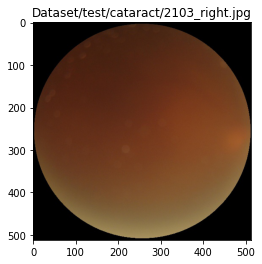

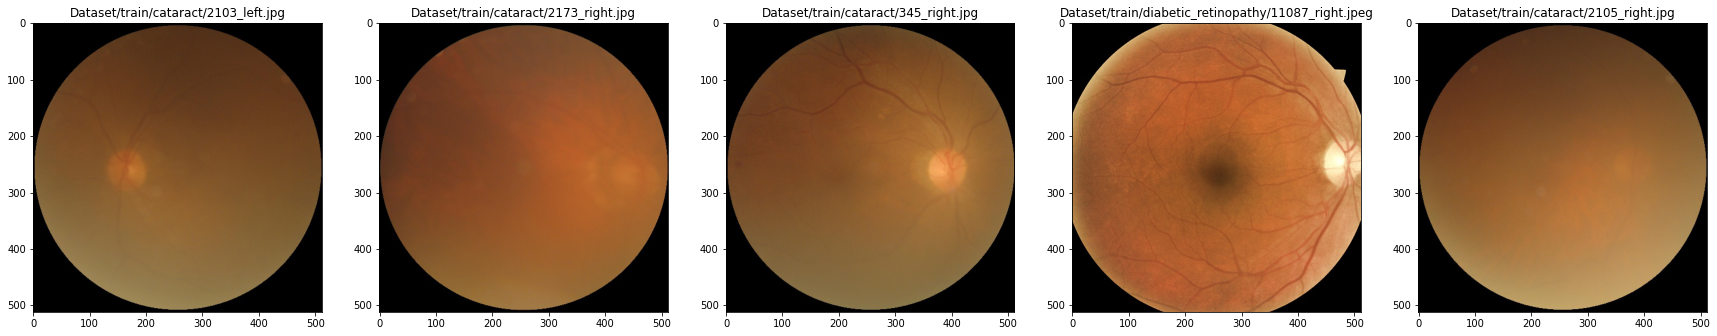

In [71]:
from PIL import Image

#fig, ax = plt.subplots(nrows=2,figsize=(10,10))
queryIdx = 2 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

# build a montage from the results and display it
#montage = build_montages(imgs, (512, 512), (5, 2))[0]
#ax[1].imshow(montage)

plt.figure(figsize=(30,500))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(result_path[i])
    plt.imshow(image)

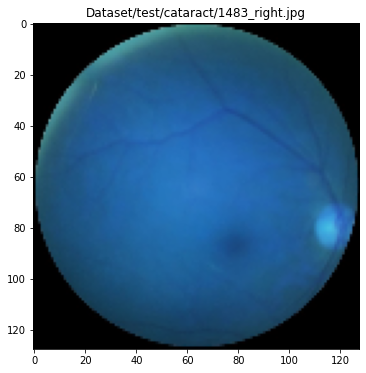

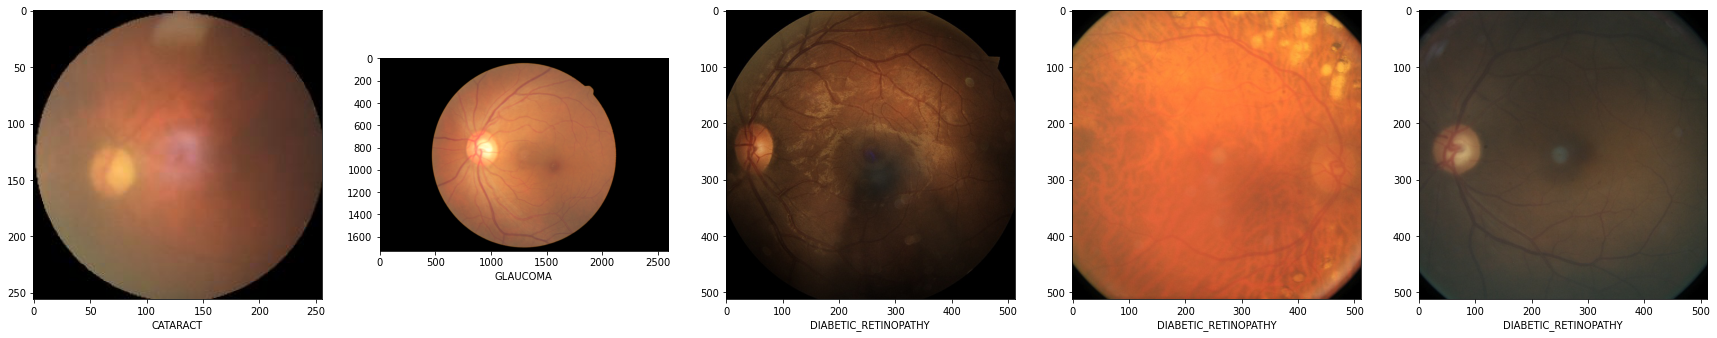

In [72]:
queryIdx = 3 # Input Index for which images 
plt.figure(figsize=(6, 6))
plt.imshow(test_x[3])
plt.title(dataset[3])
plt.show()

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=5)
labels_ret = [training_indexed["labels"][r[1]] for r in results]

i = 0
f, axs = plt.subplots(1, 5)
f.set_figheight(20)
f.set_figwidth(30)
for label in labels_ret:
    #axs[i].imshow(dataset_train[results[i][1]])
    axs[i].imshow(np.array(Image.open(dataset_train[results[i][1]])))
    axs[i].set_xlabel(label.upper())
    i += 1
plt.show()